## Set random seed to get more reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [2]:
import os
import numpy as np
import pandas as pd

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

## Select base model

In [9]:
metrics =[pd.read_csv('../Disease-diagnosis/experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Train'), index_col=0)[['ROC-AUC']].rename(columns=lambda x: x + '_' + str(i))
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
#avg = overall.T.groupby(by=overall.columns.to_series().apply(lambda x: '-'.join(x.split('-')[0:2]) + '(' + x.split('-')[3] + ')')).mean().T
#avg = avg.reset_index()
overall.mean().idxmax()

'ROC-AUC_3'

## Construct ontology using mapper file of source samples

In [19]:
!awk -F ',' '{print $5}' dataFiles/CRC_samples_stages.csv | grep -v "Env" | sort | uniq  > microbiomes.txt
!cat microbiomes.txt
!expert construct -i microbiomes.txt -o ontology.pkl

root:CRC (stage 0)
root:CRC (stage I)
root:CRC (stage II)
root:CRC (stage III)
root:CRC (stage IV)
Reading microbiome structure...
Generating Ontology...
100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
root
├── root:CRC (stage 0)
├── root:CRC (stage I)
├── root:CRC (stage II)
├── root:CRC (stage III)
└── root:CRC (stage IV)

Done


## Set hyper-parameters for training process

In [4]:
init = HeUniform(seed=2)
sig_init = GlorotUniform(seed=2)
phylogeny_path = find_expert_resource('resources/phylogeny.csv')
ontology = load_otlg('ontology.pkl')
phylogeny = pd.read_csv(phylogeny_path, index_col=0)
lrreducer = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-5, verbose=5, factor=0.1)
stopper = EarlyStopping(monitor='val_loss', patience=15, verbose=5, restore_best_weights=True)
callbacks = [lrreducer, stopper]
phylogeny = pd.read_csv(find_expert_resource('resources/phylogeny.csv'), index_col=0)
optimizer = Adam(lr=1e-4)
metrics = [BinaryAccuracy(name='acc'), AUC(name='AUC')]
loss = BinaryCrossentropy()
epochs = 2000
batch_size = 32
validation_split = 0.1

## Preprocess the data, using EXPERT's command-line API 

In [23]:
%%bash

for((i=0; i<5; i++)); do \
ls experiments/exp_$i/QueryCM.tsv.gz > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/QueryCM.h5; \
ls experiments/exp_$i/SourceCM.tsv.gz > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/SourceCM.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/SourceMapper.csv.gz -o experiments/exp_$i/SourceLabels.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/QueryMapper.csv.gz -o experiments/exp_$i/QueryLabels.h5; \
done
#rm tmp

Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       571
Unknown      0
dtype: int64
root:CRC (stage 0)       15
root:CRC (stage I)      177
root:CRC (stage II)     117
root:CRC (stage III)     84
root:CRC (stage IV)     178
Unknown                   0
dtype: int64
Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       64
Unknown     0
dtype: int64
root:CRC (stage 0)       1
root:CRC (stage I)      19
root:CRC (stage II)      9
root:CRC (stage III)     9
root:CRC (stage IV)     26
Unknown                  0
dtype: int64
Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       571
Unknown      0
dtype: int64
root:CRC (stage 0)       13
root:CRC (stage I)      180
root:CRC (stage II)     114
root:CRC (stage III)     80
root:CRC (stage IV)     184
Unknown                   0
dtyp

100%|██████████| 2/2 [00:00<00:00, 28.92it/s]


## Evaluate the model 

In [32]:
%%bash
for i in {0,1,2,3,4}; do
    mkdir running_$i;
    expert train -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/TrainModel;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/TrainModel -o experiments/exp_$i/SearchResult_Train;
    expert evaluate -i experiments/exp_$i/SearchResult_Train -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Train -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_HM \
            -m HumanModel/ --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_HM -o experiments/exp_$i/SearchResult_Adapt_ft_HM;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_HM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_HM -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_DM \
            -m ../Disease-diagnosis/experiments/exp_3/TrainModel/ --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult_Adapt_ft_DM;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_DM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_DM -S 0;
done

Reordering labels and samples...
Total matched samples: 571
N. NaN in input features: 0
           mean       std
0      0.000000  0.000000
1      0.000000  0.000000
2      0.000000  0.000000
3      0.015062  0.041284
4      0.015041  0.041268
...         ...       ...
18013  0.000061  0.000243
18014  0.000000  0.000000
18015  0.002382  0.011947
18016  0.002317  0.011715
18017  0.000000  0.000000

[18018 rows x 2 columns]
Pre-training using Adam with lr=1e-05...
Epoch 1/2
1/1 [==============================] - 0s 411ms/step - loss: 0.7021 - acc: 0.4877 - val_loss: 0.7029 - val_acc: 0.5069
Epoch 2/2
1/1 [==============================] - 0s 22ms/step - loss: 0.6914 - acc: 0.5099 - val_loss: 0.6967 - val_acc: 0.5448
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18018)]           0         
________________________________________________________

mkdir: cannot create directory ‘running_2’: File exists
2020-11-26 13:23:18.622388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-26 13:23:18.629832: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499960000 Hz
2020-11-26 13:23:18.631653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563da94111d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-26 13:23:18.631681: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-26 13:23:19.640297: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 144288144 exceeds 10% of free system memory.
2020-11-26 13:23:20.7306

## Visualize the evaluation result

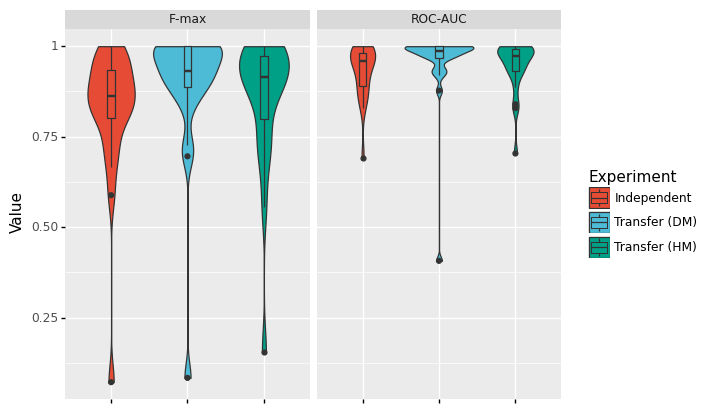

<ggplot: (8737394568509)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure.png


In [86]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, suffix), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, suffix)).dropna()
        for i in range(5) for suffix in ['Train', 'Adapt_ft_DM', 'Adapt_ft_HM']]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))

from plotnine import *
plot = (ggplot(overall, aes(x='Experiment', y='value', fill='Experiment'))
         + geom_violin()
         + geom_boxplot(width=0.1)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(axis_title_x=element_blank(), axis_text_x=element_blank())
         + xlab('Experiment')
         + ylab('Value')
         + facet_wrap('Metric'))
print(plot)
plot.save('Figure.pdf', dpi=120, width=4, height=3)
plot.save('Figure.png', dpi=120, width=4, height=3)